In [2]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#!pip install wfdb

In [4]:
# 데이터베이스와 VF 발생 시간 목록
databases = [
    ('30', '07:54:33'),
    ('31', '13:42:24'),
    ('32', '16:45:18'),
    ('33', '04:46:19'),
    ('34', '06:35:44'),
    ('35', '24:34:56'),
    ('36', '18:59:01'),
    ('37', '01:31:13'),
    ('38', '08:01:54'),
    ('39', '04:37:51'),
    #('40', None),  # pacing, no VF
    ('41', '02:59:24'),
    #('42', None),  # no VF
    ('43', '15:37:11'),
    ('44', '19:38:45'),
    ('45', '18:09:17'),
    ('46', '03:41:47'),
    ('47', '06:13:01'),
    ('48', '02:29:40'),
    #('49', None),  # pacing, no VF
    ('50', '11:45:43'),
    ('51', '22:58:23'),
    ('52', '02:32:40')
]

In [7]:
# ECG 데이터와 주석 파일 로드
data_path = '../data/sudden-cardiac-death-holter-database-1.0.0/'
save_path = '/datapath/vf_before_min_60_120/'
#record = wfdb.rdrecord(data_path + db_number)  # 100번 기록을 예로 사용 (MIT-BIH Arrhythmia Database)

In [8]:
# 시간 문자열을 초로 변환하는 함수
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [17]:
# 주석 파일을 로드하여 'N' 태그 연속 구간을 찾는 함수
def find_n_segments(annotation, fs, min_length=20):
    n_segments = []
    n_count = 0
    segment_start = None
    
    for i in range(len(annotation.symbol)):
        if annotation.symbol[i] == 'N':
            if segment_start is None:
                segment_start = annotation.sample[i]
            n_count += 1
        else:
            if n_count >= min_length:
                n_segments.append((segment_start, annotation.sample[i-1]))
            n_count = 0
            segment_start = None
    
    if n_count >= min_length:
        n_segments.append((segment_start, annotation.sample[-1]))
    
    return n_segments

In [9]:
# 데이터 처리 함수
def process_data(db_number, vf_start_time_str, data_path, save_path):
    # 데이터 로드
    record = wfdb.rdrecord(data_path + db_number)
    annotation = wfdb.rdann(data_path + db_number. 'atr')
                            
    fs = record.fs

    # 'N' 태그 연속 구간 찾기
    n_segments = find_n_segments(annotation, fs, min_length=20)

    # VF 발생 시간 (초 단위로 변환)
    vf_start_time = time_to_seconds(vf_start_time_str)
    
    # 시간대 간격 (초 단위)
    interval_1hour = 60 * 60
    interval_30min = 30 * 60
    
    # 20초 간격으로 샘플 번호 계산
    samples_20sec = 20 * fs
    
    # VF 발생 지점의 1시간 전과 30분 전 샘플 번호
    sample_1hour_before = vf_start_time - interval_1hour
    sample_30min_before = vf_start_time - interval_30min

    # ECG 데이터 추출
    data_1hour_to_30min = record.p_signal[
        int(sample_1hour_before * fs) : int(sample_30min_before * fs) + samples_20sec]
    
    split_and_save_data(data_1hour_to_30min, f'db{db_number}', samples_20sec, save_path)

In [10]:
# 20초 단위로 데이터를 나누어 저장하는 함수
def split_and_save_data(data, db_number, samples_20sec, save_path):
    num_segments = len(data) // samples_20sec
    for i in range(num_segments):
        segment = data[i * samples_20sec:(i + 1) * samples_20sec]
        filename = f'{db_number}_segment_{i+1}.npy'
        np.save(save_path + filename, segment)

In [48]:
# 데이터 처리 반복
for db_number, vf_start_time_str in databases:
    if vf_start_time_str is not None:  # VF 발생 시간이 없는 데이터는 스킵
        process_data(db_number, vf_start_time_str, data_path, save_path)
    else:
        print(f'Skipping database {db_number} due to no VF onset time.')

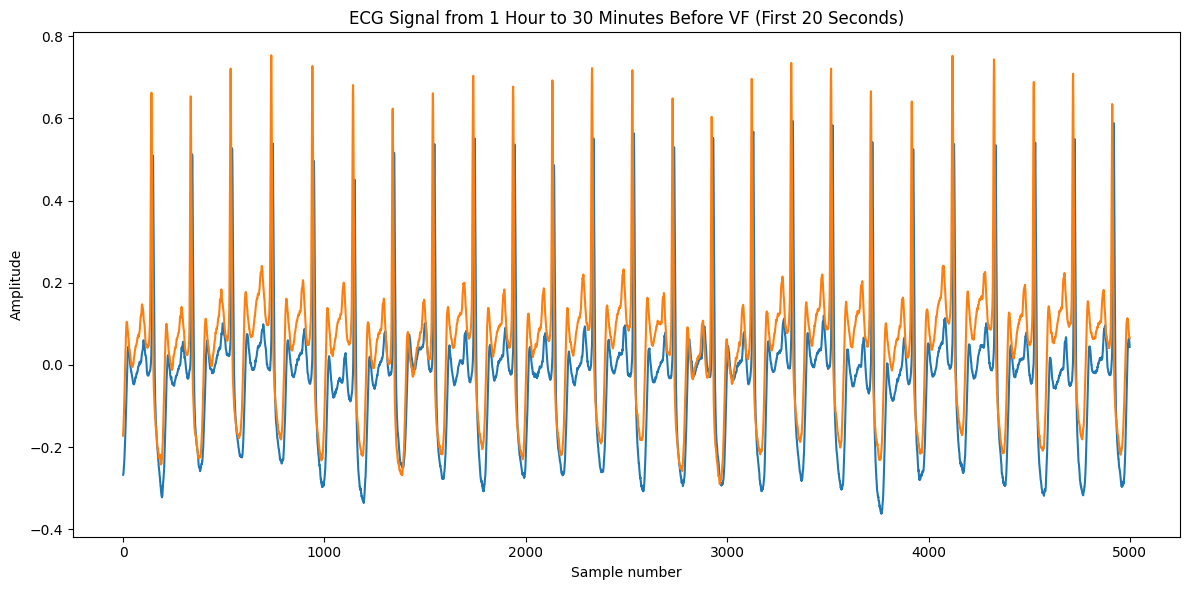

In [40]:
# 데이터 시각화 (옵션)
plt.figure(figsize=(12, 6))

# 첫 번째 20초 데이터 시각화
plt.plot(data_1hour_to_30min[:samples_20sec])
plt.title('ECG Signal from 1 Hour to 30 Minutes Before VF (First 20 Seconds)')
plt.xlabel('Sample number')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

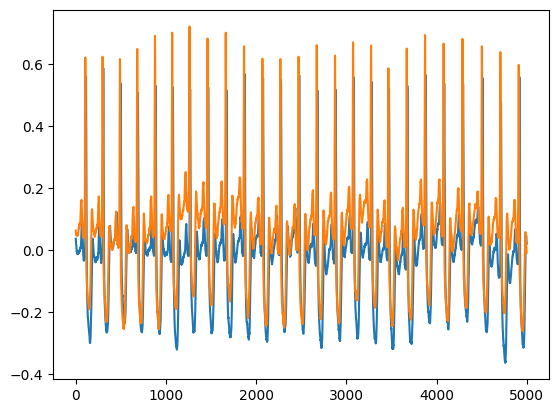

In [51]:
plt.plot(np.load('/datapath/vf_before_min_30_60/db30_segment_2.npy'))
plt.show()

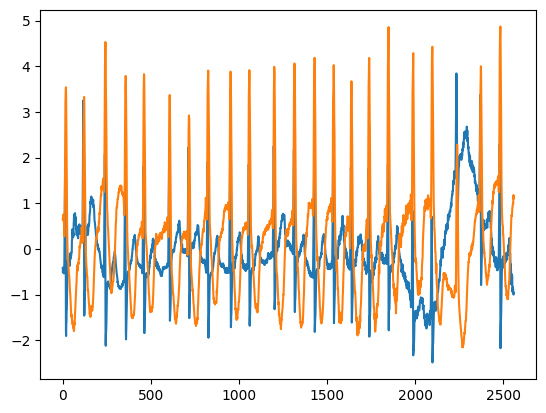

In [59]:
plt.plot(np.load('/datapath/vf_before_min_30_60/36_segment_3.npy'))
plt.show()

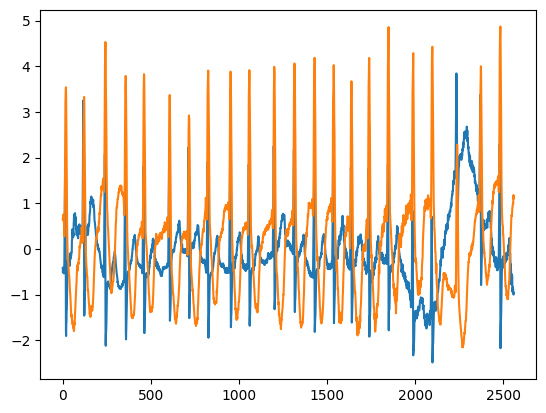

In [11]:
plt.plot(np.load('/datapath/vf_before_min_30_60/36_segment_3.npy'))
plt.show()

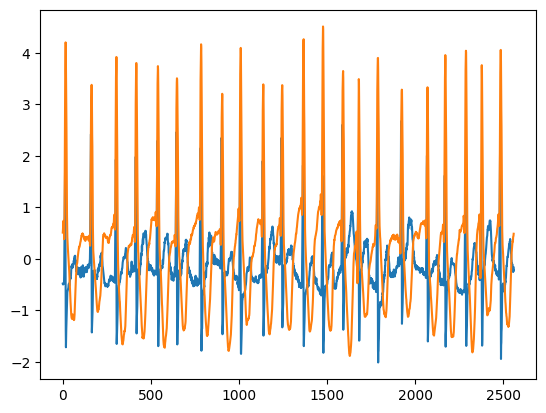

In [16]:
plt.plot(np.load('/datapath/vf_before_min_30_60/36_segment_11.npy'))
plt.show()

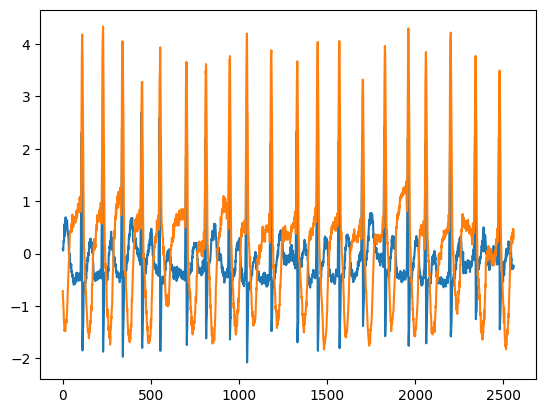

In [57]:
plt.plot(np.load('/datapath/vf_before_min_30_60/36_segment_5.npy'))
plt.show()